In [2]:
import importlib
from SpLSI import generate_topic_model as gen_model
from SpLSI import utils 
from SpLSI import splsi_
import numpy as np
import pandas as pd
import networkx as nx
import community as community_louvain  
from sklearn.metrics.pairwise import euclidean_distances
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from types import SimpleNamespace
import time
import statistics
import contextlib
import random
import os
import sys
import warnings
import community as community_louvain  
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
# from rpy2.robjects import pandas2rix
from rpy2.robjects import numpy2ri
from scipy.linalg import inv, sqrtm
import cvxpy as cp

/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
importlib.reload(gen_model)
importlib.reload(splsi_)
importlib.reload(utils)

<module 'SpLSI.utils' from '/Users/zhangzeyu/Downloads/research/SpLSI/SpLSI/utils.py'>

Running spatial HOSVD...
SpatialSVD ran for 0 steps.
Running SPOC...
Running spatial HOSVD...
Initializing...
Number of selected columns: 98
SpatialSVD ran for 0 steps.
Running SPOC...
Running spatial HOSVD...
SpatialSVD ran for 0 steps.
Running SPOC...
Running spatial HOSVD...
Initializing...
Number of selected columns: 100
SpatialSVD ran for 0 steps.
Running SPOC...
Running spatial HOSVD...
SpatialSVD ran for 0 steps.
Running SPOC...
Running spatial HOSVD...
Initializing...
Number of selected columns: 101
SpatialSVD ran for 0 steps.
Running SPOC...
Running spatial HOSVD...
SpatialSVD ran for 0 steps.
Running SPOC...
Running spatial HOSVD...
Initializing...
Number of selected columns: 104
SpatialSVD ran for 0 steps.
Running SPOC...
Running spatial HOSVD...
SpatialSVD ran for 0 steps.
Running SPOC...
Running spatial HOSVD...
Initializing...
Number of selected columns: 90
SpatialSVD ran for 0 steps.
Running SPOC...
Running spatial HOSVD...
SpatialSVD ran for 0 steps.
Running SPOC...
Run

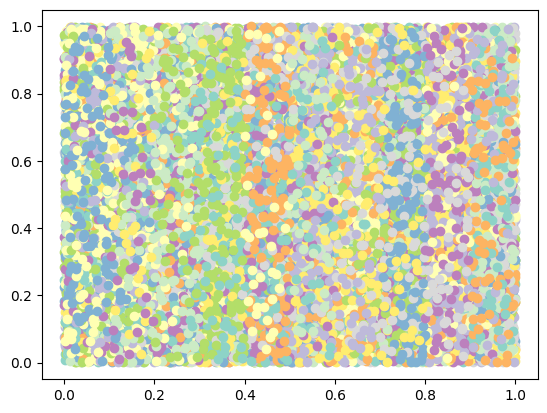

In [46]:
N = 800
U_error = []
V_error = []
U_error_sparsity = []
V_error_sparsity = []
p_list = [1500, 3000, 4500, 6000, 7500, 9000]

for p in p_list:
    U_error_runs = []
    V_error_runs = []
    U_error_sparsity_runs = []
    V_error_sparsity_runs = []
    
    for _ in range(10): 
        k = 10
        m = 100
        
        coords_df = utils.generate_graph(100, N, 30, k, 0.05)
        utils.plot_scatter(coords_df)
    
        W = utils.generate_W_strong(coords_df, 100, N, 30, k, 0.05) 
        random_matrix = np.random.randn(p-k, N)
        orthogonal_component = random_matrix - (random_matrix @ W.T) @ W
        orthogonal_matrix, _ = np.linalg.qr(orthogonal_component)
        # no need when p > n
        # orthogonal_matrix = orthogonal_matrix.T
        combined_matrix = np.vstack((W, orthogonal_matrix))
    
        V1 = np.zeros((p, k))
        V1[0:m, 0:k] = np.random.uniform(0, 1, (m, k))
    
        U_tilde = V1[0:m, 0:k]
        U_hat = U_tilde @ sqrtm(inv(U_tilde.T @ U_tilde))
        V1[0:m, 0:k] = U_hat
        V2 = np.random.uniform(0, 1, (p, p-k))
        V2 = V2 - (V1 @ V1.T @ V2)
        V2 = V2 @ sqrtm(inv(V2.T @ V2))
    
        V_combined = np.hstack((V1, V2))
    
        alpha = 1
        delta = 0.5
        Lambda1 = np.diag([alpha] * k)
        Lambda2 = np.diag([alpha - delta] * (p - k))
        Lambda = np.block([[Lambda1, np.zeros((k, p - k))],
                           [np.zeros((p - k, k)), Lambda2]])
    
        X = combined_matrix.T @ Lambda @ V_combined.T
        X = X + np.random.normal(0, 0.02, X.shape)

        weights, edge_df = utils.generate_weights_edge(coords_df, k, 0.05)
        model_hooi = splsi_.SpLSI_(
            lamb_start=0.001, step_size=1.2, grid_len=35, maxiter=0, initialize=False,
            method="hooi", verbose=0, eps=1e-5, L_inv_=False,
            fast_option=True, sparsity=False
        )
        model_hooi.fit(X, k, edge_df, weights)
    
        model_hooi_sparsity = splsi_.SpLSI_(
            lamb_start=0.001, step_size=1.2, grid_len=35, maxiter=0, initialize=True,
            method="hooi", verbose=0, eps=1e-5, L_inv_=False,
            fast_option=True, sparsity=False
        )
        model_hooi_sparsity.fit(X, k, edge_df, weights)
    

        U = model_hooi.U
        V_hat = model_hooi.V
        U_sparsity = model_hooi_sparsity.U
        V_hat_sparsity = model_hooi_sparsity.V
    

        l2_spectral = utils.get_l2_err(W, U)
        l2_spectral_sparsity = utils.get_l2_err(W, U_sparsity)
        l2_spectral_1 = utils.get_l2_err(V1.T, V_hat)
        l2_spectral_sparsity_1 = utils.get_l2_err(V1.T, V_hat_sparsity)
    
        U_error_runs.append(l2_spectral)
        V_error_runs.append(l2_spectral_1)
        U_error_sparsity_runs.append(l2_spectral_sparsity)
        V_error_sparsity_runs.append(l2_spectral_sparsity_1)
    

    U_error.append(np.mean(U_error_runs))
    V_error.append(np.mean(V_error_runs))
    U_error_sparsity.append(np.mean(U_error_sparsity_runs))
    V_error_sparsity.append(np.mean(V_error_sparsity_runs))

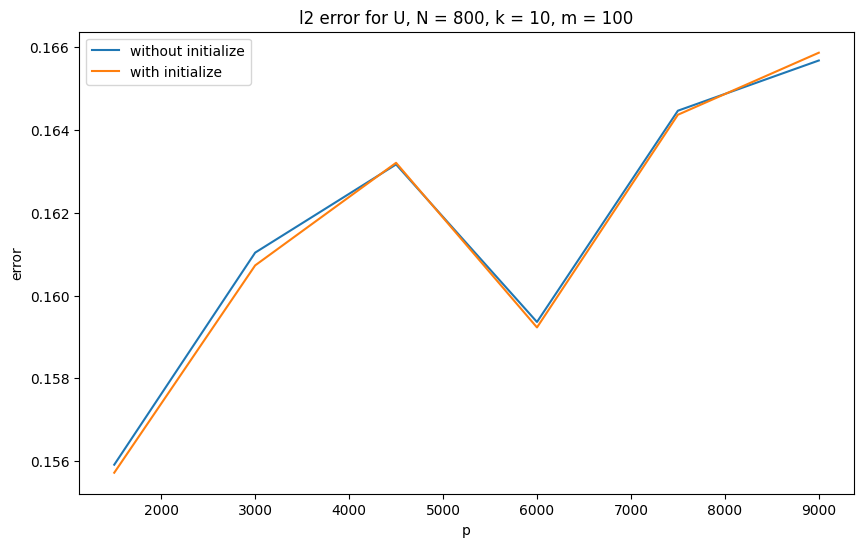

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(p_list, U_error, label='without initialize')
plt.plot(p_list, U_error_sparsity, label='with initialize')
plt.xlabel("p")
plt.ylabel("error")
plt.title("l2 error for U, N = 800, k = 10, m = 100")
plt.legend()
plt.show()

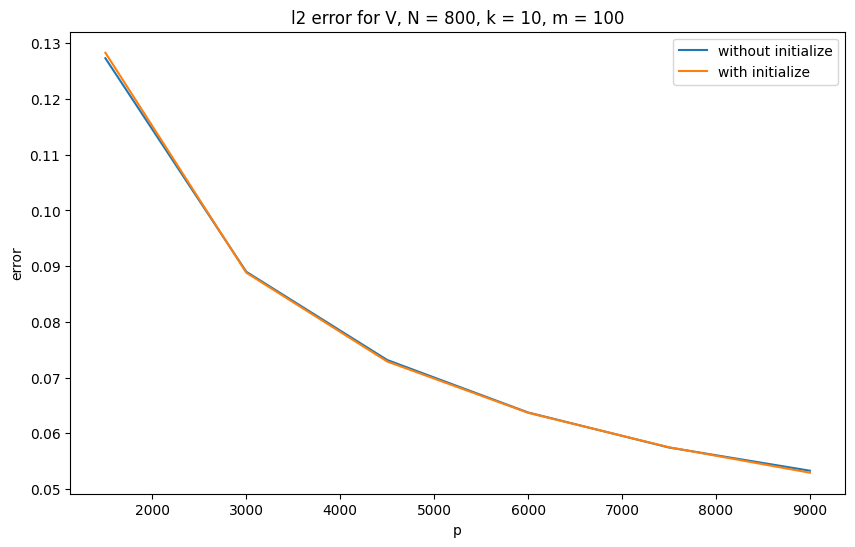

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(p_list, V_error, label='without initialize')
plt.plot(p_list, V_error_sparsity, label='with initialize')
plt.xlabel("p")
plt.ylabel("error")
plt.title("l2 error for V, N = 800, k = 10, m = 100")
plt.legend()
plt.show()

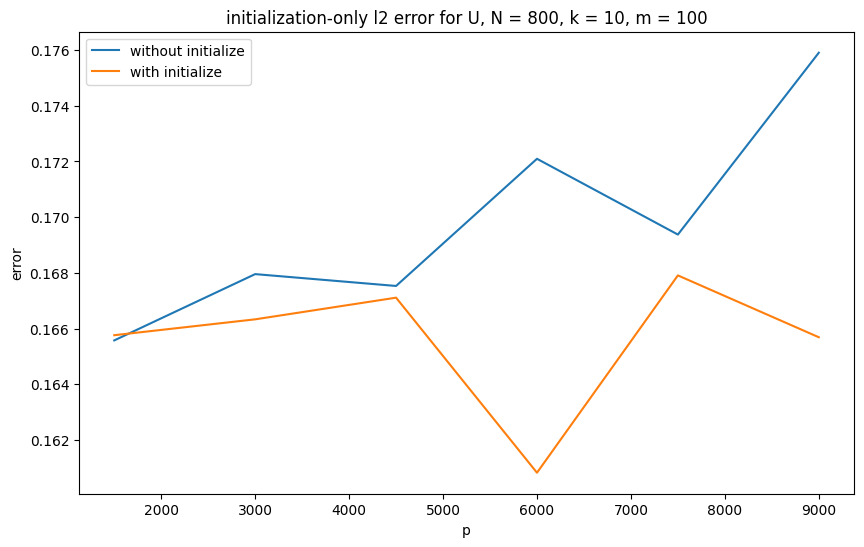

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(p_list, U_error, label='without initialize')
plt.plot(p_list, U_error_sparsity, label='with initialize')
plt.xlabel("p")
plt.ylabel("error")
plt.title("initialization-only l2 error for U, N = 800, k = 10, m = 100")
plt.legend()
plt.show()

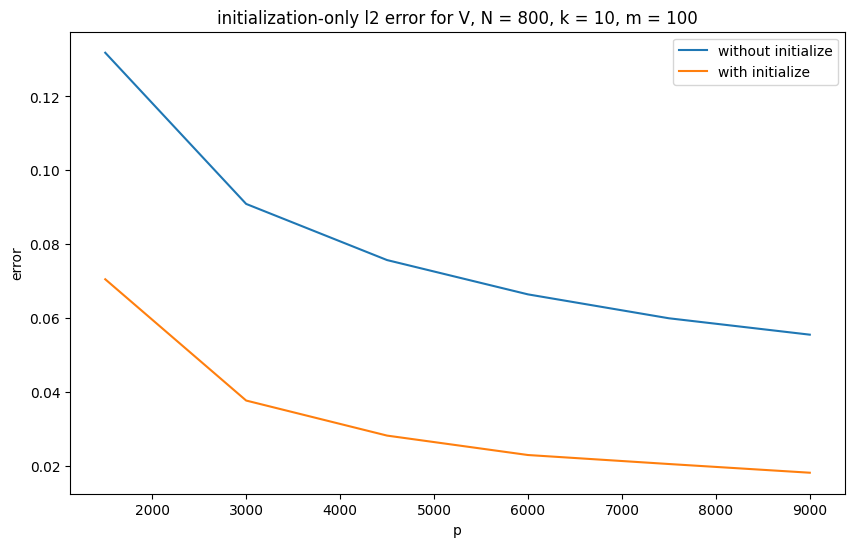

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(p_list, V_error, label='without initialize')
plt.plot(p_list, V_error_sparsity, label='with initialize')
plt.xlabel("p")
plt.ylabel("error")
plt.title("initialization-only l2 error for V, N = 800, k = 10, m = 100")
plt.legend()
plt.show()

True


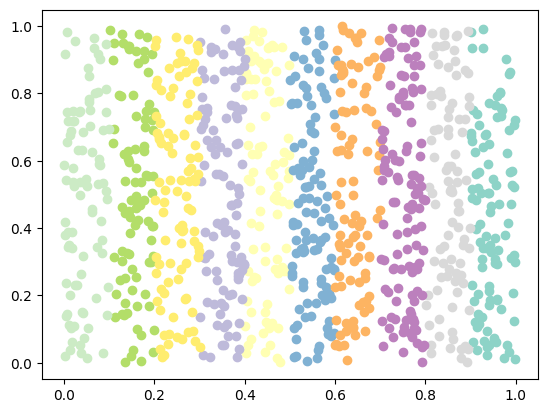

In [4]:
p= 600
m = 200
k = 10
coords_df = utils.generate_graph(100, 1000, 30, k, 0.05)
utils.plot_scatter(coords_df)

W = utils.generate_W_strong(coords_df, 100, 1000, 30, k, 0.05) 
random_matrix = np.random.randn(p-k, 1000)
orthogonal_component = random_matrix - (random_matrix @ W.T) @ W
orthogonal_matrix, _ = np.linalg.qr(orthogonal_component.T) 
orthogonal_matrix = orthogonal_matrix.T
combined_matrix = np.vstack((W, orthogonal_matrix))
is_unitary = np.allclose(combined_matrix @ combined_matrix.T, np.eye(p), atol=1e-8)
print(is_unitary)

V1 = np.zeros((p, k))
V1[0:m, 0:k] = np.random.uniform(0, 1, (m, k))

U_tilde = V1[0:m, 0:k]
U_hat = U_tilde @ sqrtm(inv(U_tilde.T @ U_tilde))
V1[0:m, 0:k] = U_hat
V2 = np.random.uniform(0, 1, (p, p-k))
V2 = V2 - (V1 @ V1.T @ V2)
V2 = V2 @ sqrtm(inv(V2.T @ V2))
V_combined = np.hstack((V1, V2))
identity_check = V_combined.T @ V_combined
tolerance = 1e-10
if np.allclose(identity_check, np.eye(p), atol=tolerance):
    print("close to the identity matrix")

alpha = 1 
delta = 0.5
Lambda1 = np.diag([alpha] * k)
Lambda2 = np.diag([alpha - delta] * (p - k))
Lambda = np.block([[Lambda1, np.zeros((k, p - k))],
                   [np.zeros((p - k, k)), Lambda2]])

X = combined_matrix.T @ Lambda @ V_combined.T
X = X + np.random.normal(0, 0.02, X.shape)
# X = utils.euclidean_proj_simplex(X, s=1)
# X = utils.multinomial_from_rows(X,n=100)

In [5]:
weights, edge_df = gen_model.generate_weights_edge(coords_df, k, 0.05)

In [6]:
model_hooi = splsi_.SpLSI_(lamb_start=0.001,step_size=1.2,grid_len=35,maxiter=0,initialize=False, method="hooi",verbose=0,eps=1e-05, L_inv_=False, fast_option=True, sparsity=False)
model_hooi.fit(X, k, edge_df, weights)

Running spatial HOSVD...
SpatialSVD ran for 0 steps.
Running SPOC...


In [7]:
model_hooi_sparsity = splsi_.SpLSI_(lamb_start=0.001,step_size=1.2,grid_len=35,maxiter=0,initialize=True, method="hooi",verbose=0,eps=1e-05, L_inv_=False, fast_option=True, sparsity=False)
model_hooi_sparsity.fit(X, k, edge_df, weights)

Running spatial HOSVD...
Initializing...
Number of selected columns: 98
SpatialSVD ran for 0 steps.
Running SPOC...


In [8]:
U = model_hooi.U
V_hat = model_hooi.V

In [9]:
U_sparsity = model_hooi_sparsity.U
V_hat_sparsity = model_hooi_sparsity.V

In [10]:
acc_spectral = utils.group_and_compare_spectral(U, coords_df)
print(f"Clustering Accuracy for Spatial PCA: {acc_spectral:.2f}")
acc_spectral_sparsity = utils.group_and_compare_spectral(U_sparsity, coords_df)
print(f"Clustering Accuracy for Spatial PCA with sparsity: {acc_spectral_sparsity:.2f}")
U_44, _, _ = svds(X.astype(float), k=10)
acc_pca_spectral = utils.group_and_compare_spectral(U_44, coords_df)
print(f"Clustering Accuracy for regular PCA: {acc_pca_spectral:.2f}")

Clustering Accuracy for Spatial PCA: 0.69
Clustering Accuracy for Spatial PCA with sparsity: 0.72
Clustering Accuracy for regular PCA: 0.69


In [11]:
l2_spectral = utils.get_l2_err(W, U)
print(f"l2 error for Spatial PCA: {l2_spectral:.4f}")
l2_spectral_sparsity = utils.get_l2_err(W, U_sparsity)
print(f"l2 error for Spatial PCA with sparsity: {l2_spectral_sparsity:.4f}")

l2 error for Spatial PCA: 0.1138
l2 error for Spatial PCA with sparsity: 0.1186


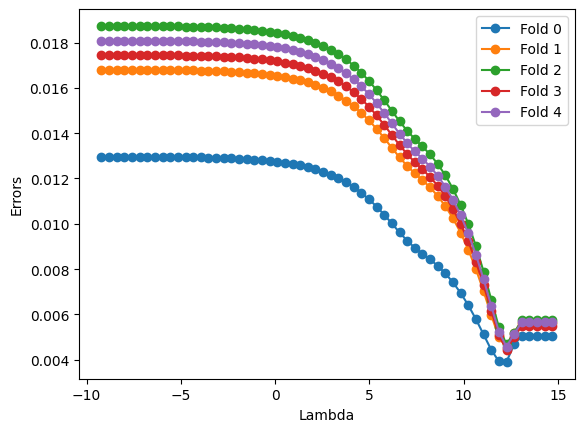

In [8]:
beta_errors = model_hooi_sparsity.beta_errs
beta_grid = (0.0001 * np.power(1.5, np.arange(35+25))).tolist()  

for j, fold_errs in beta_errors["fold_errors"].items():
    plt.plot(np.log(beta_grid), fold_errs, label=f"Fold {j}", marker="o")
plt.xlabel("Lambda")
plt.ylabel("Errors")
plt.legend()
plt.show()

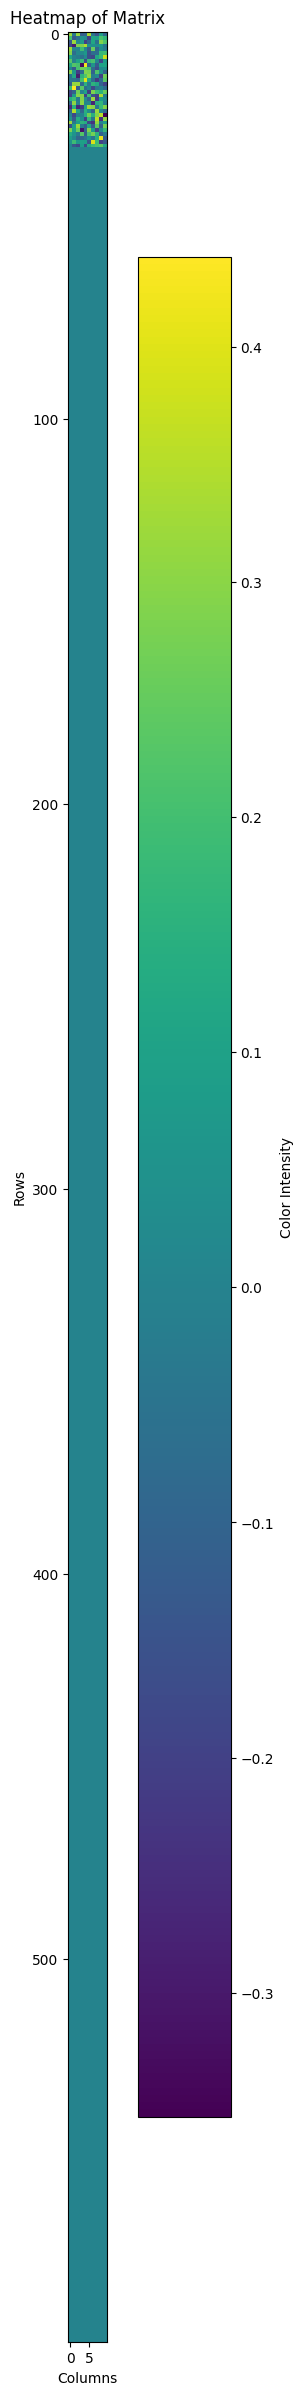

In [30]:
plt.figure(figsize=(8, 30))
plt.imshow(V1, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Color Intensity')  
plt.title("Heatmap of Matrix")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

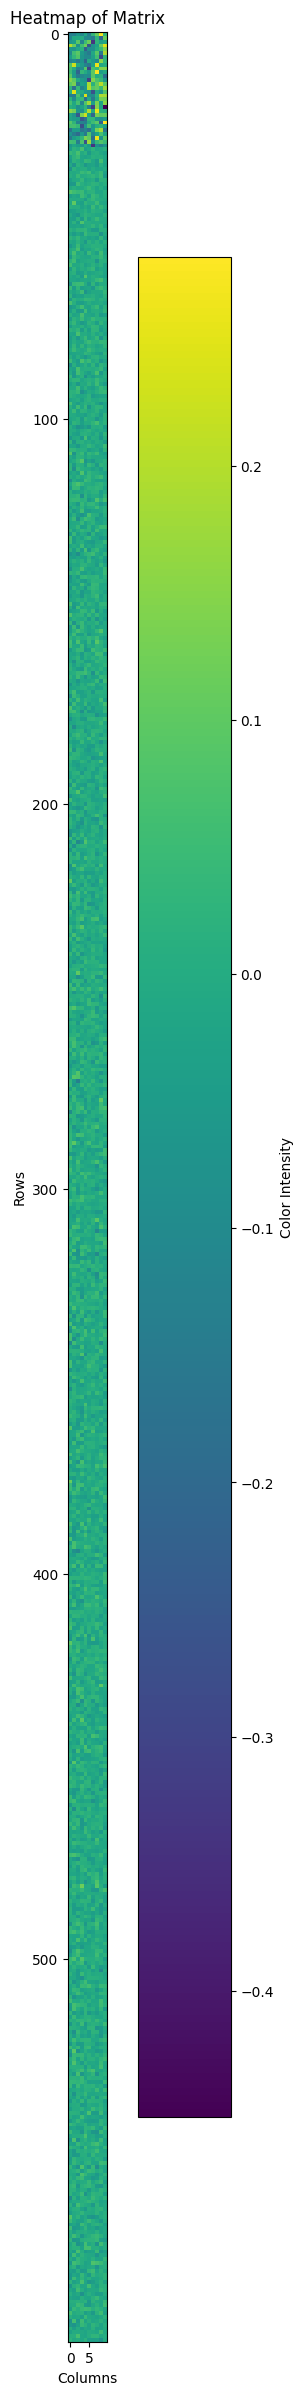

In [32]:
plt.figure(figsize=(8, 30))
plt.imshow(V_hat, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Color Intensity')  
plt.title("Heatmap of Matrix")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

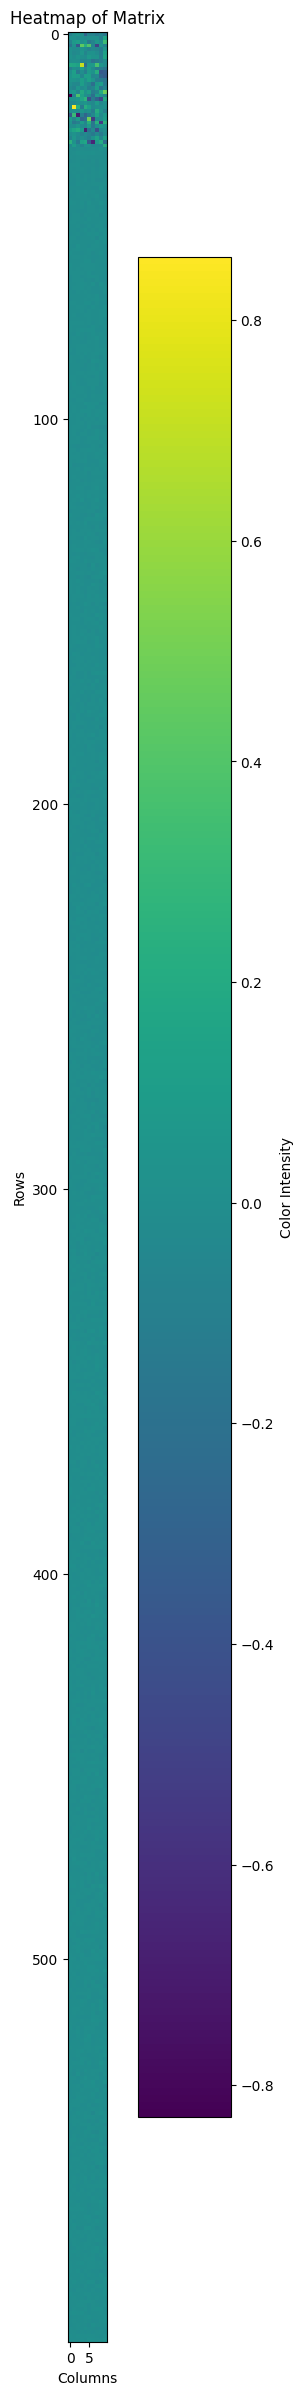

In [34]:
plt.figure(figsize=(8, 30))
plt.imshow(V_hat_sparsity, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Color Intensity')  
plt.title("Heatmap of Matrix")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

In [29]:
counts = X.T  # Transpose counts matrix as required
location = coords_df.iloc[:, :2].to_numpy()  # Extract the first two columns for coordinates

counts_r = numpy2ri.py2rpy(counts)
location_r = numpy2ri.py2rpy(location)
robjects.globalenv['counts_r'] = counts_r
robjects.globalenv['location_r'] = location_r

robjects.r('rownames(counts_r) <- 1:nrow(counts_r)')
robjects.r('colnames(counts_r) <- 1:ncol(counts_r)')
robjects.r('rownames(location_r) <- 1:nrow(location_r)')

robjects.r('''
library(SpatialPCA)

ST <- CreateSpatialPCAObject(
    counts = counts_r,
    location = location_r,
    project = "SpatialPCA",
    gene.type = "spatial",
    sparkversion = "spark",
    min.loctions = 2,
    min.features = 10
)

# 2. Build the kernel with Gaussian type
ST <- SpatialPCA_buildKernel(
    ST,
    kerneltype = "gaussian",
    bandwidthtype = "SJ"
)

# 3. Estimate loadings
ST <- SpatialPCA_EstimateLoading(
    ST,
    fast = FALSE,
    SpatialPCnum = 10
)

# 4. Perform SpatialPCA
ST <- SpatialPCA_SpatialPCs(
    ST,
    fast = FALSE
)
''')

SpatialPC = robjects.r('ST@SpatialPCs')
print(utils.group_and_compare_spectral(numpy2ri.rpy2py(SpatialPC).T, coords_df))

R[write to console]: Warning:
R[write to console]:  Data is of class matrix. Coercing to dgCMatrix.



## Use SCTransform function in Seurat to normalize data. 


R[write to console]: Running SCTransform on assay: RNA

R[write to console]: Running SCTransform on layer: counts

R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Variance stabilizing transformation of count matrix of size 100 by 1000

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 100 genes, 1000 cells

R[write to console]: Second step: Get residuals using fitted parameters for 100 genes

R[write to console]: Computing corrected count matrix for 100 genes

R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5250001 secs

R[write to console]: Determine variable features

R[write to console]: Centering data matrix

  |                                                                            
  |                                                        

## Use spark.test function in SPARK package to select spatially variable genes. 
## ===== SPARK INPUT INFORMATION ==== 
## number of total samples:  1000 
## number of total features:  100 
## number of adjusted covariates:  0 
# fitting normalized count-based spatial model under the null hypothesis ... 
## testing Gaussian kernel: 1...
## testing Periodic kernel: 1...
## testing Gaussian kernel: 2...
## testing Periodic kernel: 2...
## testing Gaussian kernel: 3...
## testing Periodic kernel: 3...
## testing Gaussian kernel: 4...
## testing Periodic kernel: 4...
## testing Gaussian kernel: 5...
## testing Periodic kernel: 5...
## Identified  17  spatial genes through spark.test function. 
The  number of significant spatial genes is less than the specified number of spatial genes. 
## Using  17  significant spatially variable genes. 
## Selected kernel type is:  gaussian  
## The bandwidth is:  0.0304782447319282  
## Calculating kernel matrix
## Finished calculating kernel matrix.
[1]